In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
personne_morale_original = pd.read_excel("../data/raw/V2.xlsx", sheet_name="personne_morale",)
personne_physique_original = pd.read_excel("../data/raw/V2.xlsx", sheet_name="personne_physique", parse_dates=["DATE_NAISSANCE"])
personne_morale = personne_morale_original.copy()
personne_physique = personne_physique_original.copy()

In [25]:
personne_physique.head()

,REF_PERSONNE,NOM_PRENOM,DATE_NAISSANCE,LIEU_NAISSANCE,CODE_SEXE,SITUATION_FAMILIALE,NUM_PIECE_IDENTITE,LIB_SECTEUR_ACTIVITE,LIB_PROFESSION,VILLE,LIB_GOUVERNORAT,VILLE_GOUVERNORAT
0,715,Personne_00001,1964-09-28 00:00:00.000,NaN,M,Marie,10000001,CADRES ET PROFESSIONS INTELLECTUELLES SUPÉRIEURES,MÉDECINS LIBÉRAUX GÉNÉRALISTES,NaN,NaN,-
1,1381,Personne_00002,1962-02-27 00:00:00.000,TUNIS,M,Marie,10000002,SERVICES PERSONNELS,CHAUFFEUR,NOUVELLE MEDINA,NaN,NOUVELLE MEDINA -
2,1947,Personne_00003,1970-04-17 00:00:00.000,TUNIS,M,Marie,10000003,COMMERCIAL,COMMERCIAL,JBAL RSAS,BEN AROUS,JBAL RSAS - BEN AROUS
3,2832,Personne_00004,1974-03-31 00:00:00.000,TUNIS,F,Marie,10000004,AUCUN,NON DEFINIE,NaN,NaN,-
4,3060,Personne_00005,1968-05-06 00:00:00.000,TUNIS,M,Marie,10000005,AUCUN,NON DEFINIE,El Hrairia,TUNIS,El Hrairia - TUNIS


In [27]:
# Verifier que les personnes morales et physiques n'ont pas de REF_PERSONNE en commun
# Si oui, il y a un risque de doublon dans les données
overlap_exists = personne_morale["REF_PERSONNE"].isin(personne_physique["REF_PERSONNE"]).any()
print(overlap_exists)

False


Les colonnes NOM_PRENOM, NUM_PIECE_IDENTITE, RAISON_SOCIALE	et MATRICULE_FISCALE n’ont aucune importance pour notre modèle. De plus, la colonne DATE_NAISSANCE sera plus utile si nous la remplaçons par une colonne AGE.

In [112]:
personne_physique.drop(columns=["NOM_PRENOM", "NUM_PIECE_IDENTITE"], inplace=True)

personne_physique = personne_physique[~personne_physique["REF_PERSONNE"].isin([572258,559230,588787,589442])] # Valeurs erronées

personne_physique["AGE"] = pd.to_datetime("today").year - pd.to_datetime(personne_physique["DATE_NAISSANCE"]).dt.year
personne_physique.drop(columns=["DATE_NAISSANCE"], inplace=True)

<Axes: xlabel='AGE'>

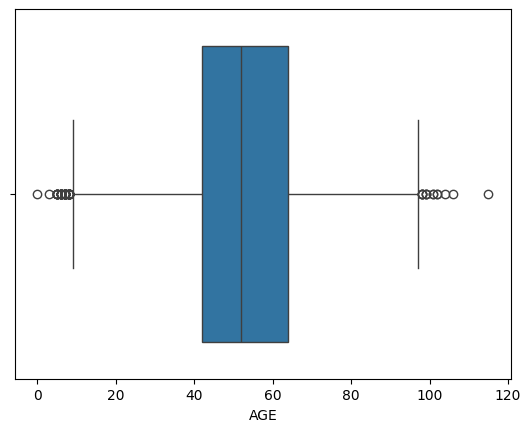

In [67]:
sns.boxplot(data=personne_physique, x="AGE")

<Axes: xlabel='AGE'>

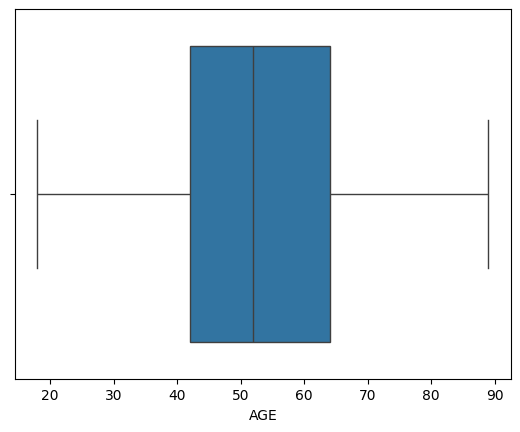

In [113]:
# Filtrer les âges anormaux
personne_physique = personne_physique[(personne_physique["AGE"] < 90) & (personne_physique["AGE"] > 17)]
sns.boxplot(data=personne_physique, x="AGE") 

Il semble que VILLE_GOUVERNORAT est une concatenation direct de VILLE et LIB_GOUVERNORAT, donc on peut se debarasser de ces deux derniers.

In [154]:
personne_physique.drop(columns=["VILLE", "LIB_GOUVERNORAT"], inplace=True)

Remplaceons les valeurs vides par "Celibataire"

In [155]:
personne_physique["SITUATION_FAMILIALE"] = personne_physique["SITUATION_FAMILIALE"].replace({
    " ": "Celibataire"
})
personne_physique["SITUATION_FAMILIALE"].value_counts()

SITUATION_FAMILIALE
Marie          30897
Celibataire    11563
Veuf(ve)         512
Divorce          342
Name: count, dtype: int64

Coulonne LIB_SECTEUR_ACTIVITE

In [156]:
personne_physique["LIB_SECTEUR_ACTIVITE"] = personne_physique["LIB_SECTEUR_ACTIVITE"].str.strip()
personne_physique["LIB_SECTEUR_ACTIVITE"] = personne_physique["LIB_SECTEUR_ACTIVITE"].replace({
    "": "AUCUN"
})
personne_physique["LIB_SECTEUR_ACTIVITE"] = (
    personne_physique["LIB_SECTEUR_ACTIVITE"].fillna("AUCUN")
)

Coulonne LIB_PROFESSION

In [157]:
personne_physique["LIB_PROFESSION"] = (
    personne_physique["LIB_PROFESSION"].fillna("NON DEFINIE")
)
personne_physique.loc[
    personne_physique["LIB_PROFESSION"].str.contains("MÉDECINS", na=False),
    "LIB_PROFESSION"
] = "MÉDECIN"
personne_physique.loc[
    personne_physique["LIB_PROFESSION"].str.contains("AGRICULTEURS", na=False),
    "LIB_PROFESSION"
] = "AGRICULTEUR"
personne_physique.loc[
    personne_physique["LIB_PROFESSION"].apply(lambda x: not isinstance(x, str)),
    ["LIB_PROFESSION"]
] = "NON DEFINIE"

In [ ]:
def group_ouvrier(prof):
    if "OUVRIERS" in prof:
        if "AGRICULTURE" in prof or "ÉLEVAGE" in prof or "MARAÎCHAGE" in prof or "HORTICULTURE" in prof:
            return "OUVRIER_AGRICULTURE"
        elif "CHIMIE" in prof or "PHARMACIE" in prof or "PLASTURGIE" in prof:
            return "OUVRIER_CHIMIE"
        elif "TRANSPORTS" in prof or "CONDUCTEURS" in prof or "MANUTENTION" in prof:
            return "OUVRIER_TRANSPORT_MANUTENTION"
        elif "BÂTIMENT" in prof or "TRAVAUX PUBLICS" in prof or "MONTAGE" in prof:
            return "OUVRIER_BATIMENT_TRAVAUX"
        elif "INDUSTRIE AGROALIMENTAIRE" in prof or "AGROALIMENTAIRE" in prof:
            return "OUVRIER_AGROALIMENTAIRE"
        elif "IMPRIMERIE" in prof or "PRESSE" in prof or "ÉDITION" in prof:
            return "OUVRIER_IMPRIMERIE"
        elif "TEXTILE" in prof or "CONFECTION" in prof or "TAILLEURS" in prof or "COUTURIÈRES" in prof:
            return "OUVRIER_TEXTILE_CONFECTION"
        elif "MÉTALLURGIE" in prof or "PRODUCTION VERRIÈRE" in prof or "CÉRAMIQUE" in prof:
            return "OUVRIER_METALLURGIE"
        elif "ÉLECTRIQUES" in prof or "TÉLÉCOMMUNICATIONS" in prof or "POSTES" in prof:
            return "OUVRIER_ELECTRICITE_TELECOM"
        elif "ASSAINISSEMENT" in prof or "DÉCHETS" in prof:
            return "OUVRIER_ASSAINISSEMENT"
        elif "MINES" in prof or "EXTRACTION" in prof:
            return "OUVRIER_MINES_EXTRACTION"
        elif "OUVRIERS" in prof:
            return "OUVRIER_AUTRES"
        
    if "EMPLOYÉS" in prof: 
        if "BANQUE" in prof:
            return "EMPLOYÉ_BANCAIRE"
        elif "ADMINISTRATIF" in prof:
            return "EMPLOYÉ_ADMINISTRATIF"
        elif "COMPTABLE" in prof or "FINANCIER" in prof:
            return "EMPLOYÉ_COMPTABLE_FINANCIER"
        elif "COMMERCIAUX" in prof:
            return "EMPLOYÉ_COMMERCIAL"
        elif "TECHNIQUES" in prof or "INFORMATIQUE" in prof:
            return "EMPLOYÉ_TECHNIQUE"
        elif "POSTE" in prof or "TÉLÉCOM" in prof or "TELECOM" in prof:
            return "EMPLOYÉ_POSTE_TELECOM"
        elif "HÔTELLERIE" in prof or "RESTAURATION" in prof or "CUISINE" in prof:
            return "EMPLOYÉ_HOTELLERIE_RESTAURATION"
        elif "MAGASIN" in prof or "LIBRE SERVICE" in prof:
            return "EMPLOYÉ_MAGASINAGE_LOGISTIQUE"
        elif "ANCIEN" in prof:
            return "EMPLOYÉ_ANCIEN"
        elif "DIVERS" in prof:
            return "EMPLOYÉ_DIVERS"
        else:
            return "EMPLOYÉ_AUTRES"
    
    elif "BH" in prof:
        return "EMPLOYÉ_BANCAIRE"

    elif "CONDUCTEURS" in prof:
        if "ENGIN" in prof or "ORDURES MÉNAGÈRES" in prof:
            return "CHAUFFEUR_ENGIN"
        elif "DU TRAVAIL EN FORGE" in prof:
            return "INDUSTRIEL"
        else:
            return "CHAUFFEUR"
    
    elif ("ELEC" in prof and "EMPLOYÉ_POSTE_TELECOM" not in prof and "LABORATOIRE" not in prof):
        return "ELECTRICIEN"
        
    else:
        return prof
    
personne_physique["LIB_PROFESSION"] = personne_physique["LIB_PROFESSION"].apply(group_ouvrier)

In [187]:
personne_physique[
    "LIB_PROFESSION"
].unique()

array(['MÉDECIN', 'CHAUFFEUR', 'COMMERCIAL', 'NON DEFINIE', 'ETUDIANTE',
       'OUVRIER_BATIMENT_TRAVAUX', 'INSPECTEUR',
       'AGENTS ADMINISTRATIFS DE LA FONCTION PUBLIQUE (Y.C. ENSEIGNEMENT)',
       'AGRICULTEUR', 'EMPLOYÉ_BANCAIRE', 'EMPLOYÉ_ADMINISTRATIF',
       'EMPLOYÉ_COMMERCIAL', 'EMPLOYÉ_ANCIEN',
       'ARTISANS DIVERS DE FABRICATION DE MACHINES',
       'OUVRIER_TRANSPORT_MANUTENTION',
       'PROFESSEURS AGRÉGÉS ET CERTIFIÉS DE L ENSEIGNEMENT SECONDAIRE',
       'CONDUCTEUR_ENGIN',
       'ADJOINTS ADMINISTRATIFS DES COLLECTIVITÉS LOCALES',
       'TRANSPORTEURS INDÉPENDANTS ROUTIERS ET FLUVIAUX, DE 0 À 9 SALARIÉS',
       'AGENTS IMMOBILIERS INDÉPENDANTS, DE 0 À 9 SALARIÉS',
       'EMPLOYÉ_TECHNIQUE', 'EMPLOYÉ_COMPTABLE_FINANCIER',
       'CADRES ADMINISTRATIFS DE FRANCE TÉLÉCOM (STATUT PUBLIC)',
       'OUVRIER_AUTRES',
       'AGENTS ADMINISTRATIFS DE L ETAT ET ASSIMILÉS (SAUF POSTE, FRANCE TÉLÉCOM)',
       'ADJOINTS ADMINISTRATIFS DE L ETAT ET ASSIMILÉS (SAUF POS

In [193]:
personne_physique.loc[
    personne_physique["LIB_PROFESSION"].str.contains("ÉLEC"), 
    "LIB_PROFESSION"
].value_counts()

LIB_PROFESSION
OPÉRATEURS QUALIFIÉS SUR MACHINES AUTOMATIQUES EN PRODUCTION ÉLECTRIQUE OU ÉLECTRONIQUE                 5
AUTRES MONTEURS CÂBLEURS EN ÉLECTRONIQUE                                                                5
AGENTS DE MAÎTRISE EN ENTRETIEN GÉNÉRAL, INSTALLATION, TRAVAUX NEUFS (HORS MÉCANIQUE, ÉLECTROMÉCANIQ    4
ARTISANS ÉLECTRICIENS DU BÂTIMENT                                                                       4
DESSINATEURS EN ÉLECTRICITÉ, ÉLECTROMÉCANIQUE ET ÉLECTRONIQUE                                           3
AGENTS DE MAÎTRISE EN MAINTENANCE, INSTALLATION EN ÉLECTROMÉCANIQUE                                     2
TECHNICIENS DE FABRICATION ET DE CONTRÔLE-QUALITÉ EN ÉLECTRICITÉ, ÉLECTROMÉCANIQUE ET ÉLECTRONIQUE      2
TECHNICIENS D INSTALLATION ET DE MAINTENANCE DES ÉQUIPEMENTS INDUSTRIELS (ÉLECTRIQUES, ÉLECTROMÉCANI    2
AGENTS DE MAÎTRISE EN FABRICATION DE MATÉRIEL ÉLECTRIQUE, ÉLECTRONIQUE                                  2
INGÉNIEURS ET CADRES D ÉTUDE, R